<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fclassification/applications/classification/sentiment_classification/Sentimix%20using%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Initial Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install contractions -q

     |████████████████████████████████| 317kB 3.9MB/s 
     |████████████████████████████████| 245kB 40.4MB/s 


Dataset can be found [here](https://github.com/gopalanvinay/thesis-vinay-gopalan)

In [3]:
train_file = '/content/drive/My Drive/train_14k_split_conll.txt'
test_file = '/content/drive/My Drive/dev_3k_split_conll.txt'

### Imports

In [132]:
import re
import time
import string
import contractions
import numpy as np
import pandas as pd

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
with open(train_file) as f:
    data = f.readlines()

In [6]:
with open(test_file, 'r') as f:
    test_data = f.readlines()

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data Parsing

In [7]:
def parse_data(data):
    sentences, sentences_info, sentiment = [], [], []
    all_langs = []
    
    single_sentence, single_sentence_info = [], []
    sent = ""
    
    for idx, each_line in enumerate(data):
        line = each_line.strip()
        tokens = line.split('\t')
        num_tokens = len(tokens)
        if num_tokens == 2:
            # add the word
            single_sentence.append(tokens[0])
            # add the word info(lang)
            single_sentence_info.append(tokens[1])
            all_langs.append(tokens[1])
        elif num_tokens == 3 and idx > 0:
            # append the sentence data
            sentences.append(single_sentence)
            sentences_info.append(single_sentence_info)
            sentiment.append(sent)
            sent = tokens[-1]
            # clear the single sentence
            single_sentence = []
            single_sentence_info = []
        # new line after the sentence
        elif num_tokens == 1:
            continue
        else:
            sent = tokens[-1]
    # for the last sentence
    if len(single_sentence) > 0:
        sentences.append(single_sentence)
        sentences_info.append(single_sentence_info)
        sentiment.append(sent)
        
    assert len(sentences) == len(sentences_info) == len(sentiment)
    return sentences, sentences_info, sentiment, all_langs

In [8]:
sentences, sentences_info, sentiment, all_langs = parse_data(data)

In [9]:
data[:30]

['meta\t4330\tneutral\n',
 'nen\tEng\n',
 'á\tO\n',
 'vist\tEng\n',
 'bolest\tEng\n',
 'vztek\tEng\n',
 'smutek\tEng\n',
 'zmatek\tHin\n',
 'osam\tHin\n',
 'ě\tO\n',
 'lost\tEng\n',
 'beznad\tEng\n',
 'ě\tO\n',
 'j\tHin\n',
 'a\tEng\n',
 'nakonec\tEng\n',
 'jen\tHin\n',
 'klid\tHin\n',
 'Asi\tHin\n',
 'takhle\tHin\n',
 'vypad\tHin\n',
 'á\tO\n',
 'm\tHin\n',
 'ů\tO\n',
 'j\tEng\n',
 'life\tEng\n',
 '...\tO\n',
 '\n',
 'meta\t41616\tneutral\n',
 '@\tO\n']

In [10]:
test_sentences, test_sentences_info, test_sentiment, test_all_langs = parse_data(test_data)

In [11]:
len(sentiment)

14000

### Data Exploration

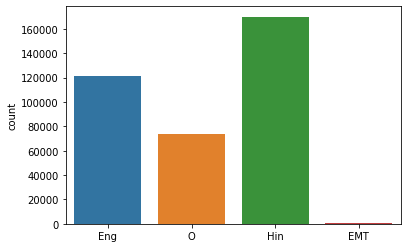

In [12]:
sns.countplot(all_langs)

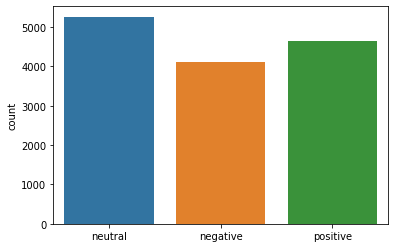

In [13]:
sns.countplot(sentiment)

In [14]:
set(sentiment)

{'negative', 'neutral', 'positive'}

In [15]:
sent_num_tokens = [len(sent) for sent in sentences]

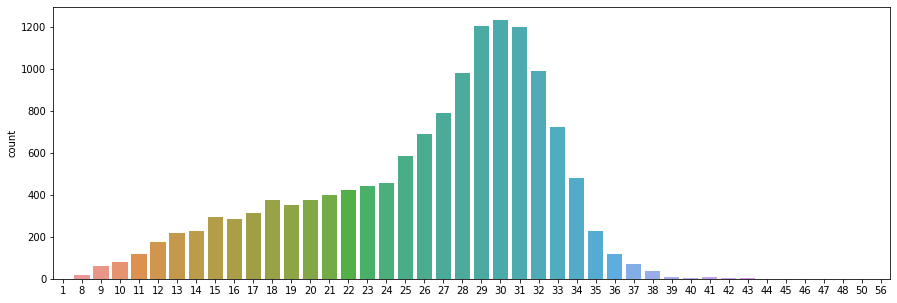

In [16]:
plt.figure(figsize=(15, 5))
sns.countplot(sent_num_tokens)

In [17]:
sentences[10]

['@',
 'ECISVEEP',
 'Can',
 'you',
 'answer',
 'miscalculated',
 'votes',
 'on',
 'each',
 'seat',
 '?',
 'One',
 'vote',
 'matters',
 '!',
 '#',
 'deshkamahatyohar',
 'hai',
 'aur',
 'apne',
 'dhji',
 '…',
 'https',
 '//',
 't',
 '.',
 'co',
 '/',
 'SuHS4mx6Dm']

In [18]:
sentences_info[10]

['O',
 'Eng',
 'Eng',
 'Eng',
 'Eng',
 'Eng',
 'Eng',
 'Eng',
 'Eng',
 'Eng',
 'O',
 'Eng',
 'Eng',
 'Hin',
 'O',
 'O',
 'Hin',
 'Hin',
 'Hin',
 'Hin',
 'Eng',
 'O',
 'Eng',
 'O',
 'Eng',
 'O',
 'Hin',
 'O',
 'Hin']

In [19]:
sentiment[0]

'neutral'

### Data Cleaning

In [20]:
url_pattern = r'https(.*)/\s\w+'
special_chars = r'[_…\*\[\]\(\)&“]'
names_with_numbers = r'([A-Za-z]+)\d{3,}'
apostee = r"([\w]+)\s'\s([\w]+)"
names = r"@[\s]*[\w]+[\s]*[_]+[\s]*[\w]+|@[\s]*[\w]+"

def preprocess_data(sentence_tokens):
    sentence = " ".join(sentence_tokens)
    sentence = " " + sentence
    # remove rt and … from string
    sentence = sentence.replace(" RT ", "")
    sentence = sentence.replace("…", "")
    # replace apostee
    sentence = sentence.replace("’", "'")
    # replace names
    sentence = re.sub(re.compile(names), " ", sentence)
    # remove special chars
    # sentence = re.sub(re.compile(special_chars), "", sentence)
    # remove urls
    sentence = re.sub(re.compile(url_pattern), "", sentence)
    ## remove duplicate characters
    # sentence = re.sub(r"(.)\1{3,}", r'\1', sentence)
    # combine only ' related words => ... it ' s ... -> ... it's ...
    sentence = re.sub(re.compile(apostee), r"\1'\2", sentence)
    # fix contractions
    sentence = contractions.fix(sentence)
    # replace names ending with numbers with only names (remove numbers)
    sentence = re.sub(re.compile(names_with_numbers), r" ", sentence)
    ## consider only printable chars (many greek, urdu, hindi chars are there)
    # sentence = [ch for ch in sentence if ch in string.printable]
    # sentence = "".join(sentence).strip()
    sentence = " ".join(sentence.split()).strip()
    return sentence

In [21]:
" ".join(sentences[1]), sentiment[1]

('@ nehantics Haan yaar neha 😔😔 kab karega woh post 😭 Usne na sach mein photoshoot karna chahiye phir woh post karega … https // tco / 5RSlSbZNtt',
 'neutral')

In [22]:
preprocess_data(sentences[1])

'Haan yaar neha 😔😔 kab karega woh post 😭 Usne na sach mein photoshoot karna chahiye phir woh post karega'

In [23]:
" ".join(sentences[29]), sentiment[29]

('Madam @ SushmaSwaraj ji we always miss you as a # videsh _ mantri',
 'positive')

In [24]:
preprocess_data(sentences[29])

'Madam ji we always miss you as a # videsh _ mantri'

In [25]:
" ".join(sentences[10]), sentiment[10]

('@ ECISVEEP Can you answer miscalculated votes on each seat ? One vote matters ! # deshkamahatyohar hai aur apne dhji … https // t . co / SuHS4mx6Dm',
 'neutral')

In [26]:
preprocess_data(sentences[10])

'Can you answer miscalculated votes on each seat ? One vote matters ! # deshkamahatyohar hai aur apne dhji'

In [27]:
%%time
processed_sentences = []

for sent in sentences:
    processed_sentences.append(preprocess_data(sent))

CPU times: user 721 ms, sys: 1.04 ms, total: 722 ms
Wall time: 723 ms


In [28]:
%%time
test_data = []

for sent in test_sentences:
    test_data.append(preprocess_data(sent))

CPU times: user 153 ms, sys: 0 ns, total: 153 ms
Wall time: 154 ms


In [29]:
sentiment_mapping = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

In [30]:
labels = [sentiment_mapping[sent] for sent in sentiment]
test_label = [sentiment_mapping[sent] for sent in test_sentiment]

### Train-Val-Test Splits

In [31]:
train_data, val_data, train_label, val_label = train_test_split(processed_sentences, labels, test_size=0.2)

In [32]:
len(train_data), len(val_data), len(test_data)

(11200, 2800, 3000)

### Train-Val-Test Distributions

Text(0.5, 0, 'Training Data')

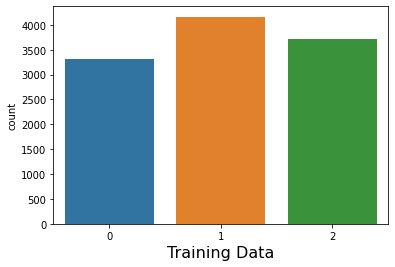

In [33]:
sns.countplot(train_label)
plt.xlabel('Training Data', fontsize=16)

Text(0.5, 0, 'Validation Data')

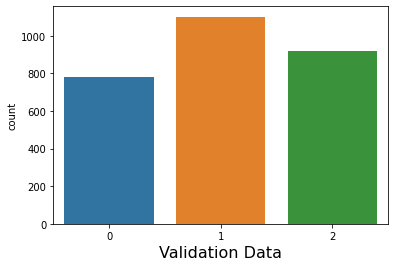

In [34]:
sns.countplot(val_label)
plt.xlabel('Validation Data', fontsize=16)

Text(0.5, 0, 'Testing Data')

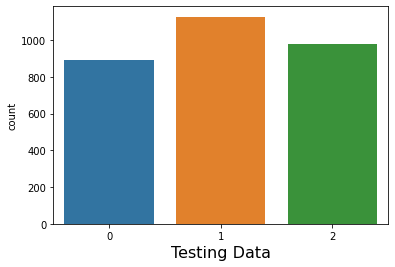

In [35]:
sns.countplot(test_label)
plt.xlabel('Testing Data', fontsize=16)

### Vocabulary

In [74]:
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [77]:
def build_vocab(sentences, threshold=15):
    """Build a simple vocabulary wrapper."""
    counter = Counter()
    for i, sent in enumerate(sentences):
        counter.update(sent.split())

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

In [78]:
vocab = build_vocab(train_data)

In [116]:
len(vocab)

1630

### Dataset Wrapper

In [80]:
class SentiMixDataSet(Dataset):
    def __init__(self, inputs, labels):
        self.sentences = inputs
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, item):
        sentence = self.sentences[item]
        sentiment = int(self.labels[item])
        
        tokens = []
        tokens.append(vocab('<start>'))
        for tok in sentence.split():
            tokens.append(vocab(tok))
        tokens.append(vocab('<end>'))
        return torch.LongTensor(tokens), sentiment

In [81]:
train_dataset = SentiMixDataSet(train_data, train_label)
val_dataset = SentiMixDataSet(val_data, val_label)
test_dataset = SentiMixDataSet(test_data, test_label)

In [83]:
# sample check
train_dataset[0]

(tensor([ 1,  3,  4,  5,  3,  6,  7,  3,  3,  7,  3,  4,  8,  9, 10, 11, 12, 13,
          7, 14, 15, 16,  2]), 1)

### DataLoaders

In [84]:
def collate_fn(data):
    data.sort(key=lambda x: len(x[0]), reverse=True)
    sentences, sentiments = zip(*data)
    
    sent_lengths = [len(sent) for sent in sentences]
    inputs = torch.zeros((len(sentences), max(sent_lengths)), dtype=torch.long)
    labels = torch.zeros(len(sentences), dtype=torch.long)

    for i, sent in enumerate(sentences):
        end = sent_lengths[i]
        inputs[i, :end] = sent[:end]
        labels[i] = sentiments[i]

    return inputs, sent_lengths, labels

In [87]:
BATCH_SIZE = 16

train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
valid_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [88]:
sample = next(iter(train_data_loader))
sample[0].shape, len(sample[1]), sample[2].shape

(torch.Size([16, 31]), 16, torch.Size([16]))

### RNN Model

In [137]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, num_layers, dropout=0.4):
        super().__init__()

        self.hid_dim = hid_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)

        self.rnn = nn.GRU(
            emb_dim,
            hid_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )

        self.fc = nn.Linear(hid_dim, 50)
        self.out = nn.Linear(50, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs, input_lengths):
        # inputs => [batch_size, seq_len]
        # input_lengths => [batch_size]

        embedded = self.dropout(self.embedding(inputs))

        packed_input = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths, batch_first=True)
        _, hidden = self.rnn(packed_input)

        hidden = hidden.view(self.num_layers, 2, -1, self.hid_dim)
        final_forward_hidden = hidden[-1, -2, :, :]
        final_backward_hidden = hidden[-1, -1, :, :]
        # final_*_hidden => [batch_size, hidden_dim]

        combined = final_forward_hidden + final_backward_hidden
        combined = self.dropout(combined)
        # combined => [batch_size, hidden_dim]

        intermediate = F.relu(self.fc(combined))
        intermediate = self.dropout(intermediate)
        logits = self.out(intermediate)
        # logits => [batch_size, output_dim]

        return logits

### Model Configurations

In [138]:
input_dim = len(vocab)
output_dim = 3
emb_dim = 200
hid_dim = 100
num_layers = 2
NUM_EPOCHS = 20
model_path = "rnn.pt"

In [139]:
model = RNNModel(input_dim, emb_dim, hid_dim, output_dim, num_layers)

In [140]:
model.to(device)

RNNModel(
  (embedding): Embedding(1630, 200)
  (rnn): GRU(200, 100, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=100, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=3, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [141]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model)} trainable parameters")


The model has 693603 trainable parameters


### Loss Criterion & Optimizer

In [142]:
lr = 1e-4
min_lr = 3e-5
lr_decay=0.5
lr_patience=2

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', lr_decay, lr_patience, verbose=True, min_lr=min_lr)

### Training Method

In [144]:
def train(iterator, clip=2.0):
    epoch_loss = 0
    model.train()
    for batch in iterator:
        sentences = batch[0].to(device)
        sentence_lengths = batch[1]
        targets = batch[2].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(sentences, sentence_lengths)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

### Validation Method

In [128]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)

In [145]:
def evaluate(iterator):
    epoch_loss = 0
    model.eval()
    epoch_acc = 0

    with torch.no_grad():
        for batch in iterator:
            sentences = batch[0].to(device)
            sentence_lengths = batch[1]
            targets = batch[2].to(device)
            logits = model(sentences, sentence_lengths)
            # logits => [batch_size, num_labels]

            loss = criterion(logits, targets)
            acc = categorical_accuracy(logits, targets)
            epoch_acc += acc.item()
            epoch_loss += loss.item()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [146]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = elapsed_time - (elapsed_mins * 60)
    return elapsed_mins, elapsed_secs

### Model Training

In [147]:
best_valid_loss = float('inf')
for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    train_loss = train(train_data_loader)
    val_loss, val_acc = evaluate(valid_data_loader)
    end_time = time.time()
    scheduler.step(val_loss)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs:.2f}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.3f}")
    
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), model_path)

Epoch: 01 | Time: 0m 25.32s
	Train Loss: 1.097 | Val Loss: 1.079 | Val Acc: 0.398
Epoch: 02 | Time: 0m 25.17s
	Train Loss: 1.083 | Val Loss: 1.039 | Val Acc: 0.444
Epoch: 03 | Time: 0m 24.84s
	Train Loss: 1.028 | Val Loss: 0.960 | Val Acc: 0.492
Epoch: 04 | Time: 0m 25.17s
	Train Loss: 0.986 | Val Loss: 0.948 | Val Acc: 0.496
Epoch: 05 | Time: 0m 25.24s
	Train Loss: 0.966 | Val Loss: 0.929 | Val Acc: 0.521
Epoch: 06 | Time: 0m 25.30s
	Train Loss: 0.950 | Val Loss: 0.919 | Val Acc: 0.535
Epoch: 07 | Time: 0m 25.29s
	Train Loss: 0.937 | Val Loss: 0.902 | Val Acc: 0.549
Epoch: 08 | Time: 0m 25.30s
	Train Loss: 0.928 | Val Loss: 0.917 | Val Acc: 0.536
Epoch: 09 | Time: 0m 25.27s
	Train Loss: 0.917 | Val Loss: 0.893 | Val Acc: 0.547
Epoch: 10 | Time: 0m 24.86s
	Train Loss: 0.903 | Val Loss: 0.895 | Val Acc: 0.547
Epoch: 11 | Time: 0m 25.31s
	Train Loss: 0.900 | Val Loss: 0.901 | Val Acc: 0.553
Epoch    12: reducing learning rate of group 0 to 5.0000e-05.
Epoch: 12 | Time: 0m 24.96s
	Train L

In [148]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

### Evaluation

In [151]:
def cal_metrics(model, data_loader):
    model.eval()
    fin_outputs = []
    fin_targets = []

    with torch.no_grad():
        for batch in data_loader:
            sentences = batch[0].to(device)
            sentence_lengths = batch[1]
            targets = batch[2].to(device)

            predictions = model(sentences, sentence_lengths)
            # predictions => [batch_size, num_labels]

            outputs = predictions.max(dim=1)[1]
            fin_targets.extend(targets.detach().cpu().numpy().tolist())
            fin_outputs.extend(outputs.detach().cpu().numpy().tolist())

    assert len(fin_outputs) == len(fin_targets)

    cf = metrics.classification_report(fin_targets, fin_outputs)
    print(cf)


In [152]:
cal_metrics(model, test_data_loader)

              precision    recall  f1-score   support

           0       0.54      0.72      0.62       890
           1       0.50      0.38      0.43      1128
           2       0.66      0.64      0.65       982

    accuracy                           0.57      3000
   macro avg       0.57      0.58      0.57      3000
weighted avg       0.56      0.57      0.56      3000

